In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import geopandas as gpd
import rasterio
from distmetrics import compute_transformer_zscore, load_trained_transformer_model
import asf_search as asf
from rasterio.crs import CRS
from shapely.geometry import Point
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import requests
import numpy as np
from requests.exceptions import HTTPError
import backoff
from rasterio.errors import RasterioIOError
from pathlib import Path
from dem_stitcher.rio_tools import reproject_profile_to_new_crs, reproject_arr_to_match_profile
import shutil
from matplotlib.colors import ListedColormap
import shapely

# Parameters

In [3]:
PRE_IMAGE_WINDOW_DAYS = 180
POST_IMAGE_WINDOW_DAYS = 30
EVENT_DATE = '2025-01-07'

AOI_NAME = 'los-angeles-fire'

In [4]:
df_la = gpd.read_file('https://raw.githubusercontent.com/codeforgermany/click_that_hood/refs/heads/main/public/data/los-angeles-county.geojson')
df_la.explore()

In [5]:
df_la['geometry'] = df_la['geometry'].buffer(.1)
df_aoi = df_la.dissolve().reset_index(drop=True)[['geometry']]
df_aoi.head()

/tmp/ipykernel_173485/3018396431.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_la['geometry'] = df_la['geometry'].buffer(.1)


,geometry
0,"MULTIPOLYGON (((-118.69502 33.52106, -118.6903..."


# Datetimes

In [6]:
event_date = datetime.strptime(EVENT_DATE, '%Y-%m-%d')
event_date

datetime.datetime(2025, 1, 7, 0, 0)

# Directory

In [7]:
out_dir = Path(f'out/{AOI_NAME}')
out_dir.mkdir(exist_ok=True, parents=True)

# AOI and Search - Interactive Portion

In [8]:
df_aoi.explore()

In [9]:
resp = asf.geo_search(intersectsWith=df_aoi.geometry[0].wkt,
                                 processingLevel='RTC',
                                 platform=asf.constants.SENTINEL1, 
                                 start=event_date - timedelta(days=PRE_IMAGE_WINDOW_DAYS),
                                 polarization=['VV'],
                                 end=event_date + timedelta(days=POST_IMAGE_WINDOW_DAYS),
                                )

["'type': 'CONVEX_HULL_INDIVIDUAL': 'report': 'Unconnected shapes: Convex-hulled each INDIVIDUAL shape to merge them together.'", "'type': 'GEOMETRY_SIMPLIFICATION': 'report': 'Shape Simplified: shape of 84 simplified to {coords_length} with proximity threshold of {threshold}'", "'type': 'REVERSE': 'report': Reversed polygon winding order"]


In [10]:
df_rtc_resp = gpd.GeoDataFrame.from_features(resp.geojson(), crs=CRS.from_epsg(4326))
df_rtc_resp['acq_dt'] = pd.to_datetime(df_rtc_resp.startTime)
df_rtc_resp['acq_date'] = pd.to_datetime(df_rtc_resp.startTime).dt.round('D').dt.date
df_rtc_resp['opera_dedup_id'] = df_rtc_resp.fileID.map(lambda file_id: '_'.join(file_id.split('_')[:5]))
df_rtc_resp.drop_duplicates(subset='opera_dedup_id', inplace=True)
df_rtc_resp.head()

,geometry,centerLat,centerLon,stopTime,fileID,flightDirection,pathNumber,processingLevel,url,startTime,...,beamModeType,s3Urls,beamMode,additionalUrls,bistaticDelayCorrection,noiseCorrection,postProcessingFilter,acq_dt,acq_date,opera_dedup_id
0,"POLYGON ((-117.49584 33.08116, -118.48335 33.2...",33.072171,-118.007472,2025-01-09T13:53:12Z,OPERA_L2_RTC-S1_T071-151234-IW2_20250109T13530...,DESCENDING,71,RTC,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2025-01-09T13:53:09Z,...,IW,[s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...,IW,[https://datapool.asf.alaska.edu/RTC/OPERA-S1/...,TRUE,TRUE,FALSE,2025-01-09 13:53:09+00:00,2025-01-10,OPERA_L2_RTC-S1_T071-151234-IW2_20250109T135309Z
1,"POLYGON ((-118.40892 33.32951, -119.27872 33.4...",33.308511,-118.859744,2025-01-09T13:53:11Z,OPERA_L2_RTC-S1_T071-151233-IW3_20250109T13530...,DESCENDING,71,RTC,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2025-01-09T13:53:08Z,...,IW,[s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...,IW,[https://datapool.asf.alaska.edu/RTC/OPERA-S1/...,TRUE,TRUE,FALSE,2025-01-09 13:53:08+00:00,2025-01-10,OPERA_L2_RTC-S1_T071-151233-IW3_20250109T135308Z
2,"POLYGON ((-117.45946 33.24678, -118.4517 33.39...",33.238107,-117.972387,2025-01-09T13:53:10Z,OPERA_L2_RTC-S1_T071-151233-IW2_20250109T13530...,DESCENDING,71,RTC,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2025-01-09T13:53:07Z,...,IW,[s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...,IW,[https://datapool.asf.alaska.edu/RTC/OPERA-S1/...,TRUE,TRUE,FALSE,2025-01-09 13:53:07+00:00,2025-01-10,OPERA_L2_RTC-S1_T071-151233-IW2_20250109T135307Z
3,"POLYGON ((-118.372 33.49509, -119.24572 33.618...",33.474233,-118.826180,2025-01-09T13:53:08Z,OPERA_L2_RTC-S1_T071-151232-IW3_20250109T13530...,DESCENDING,71,RTC,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2025-01-09T13:53:05Z,...,IW,[s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...,IW,[https://datapool.asf.alaska.edu/RTC/OPERA-S1/...,TRUE,TRUE,FALSE,2025-01-09 13:53:05+00:00,2025-01-10,OPERA_L2_RTC-S1_T071-151232-IW3_20250109T135305Z
4,"POLYGON ((-117.42592 33.41322, -118.41419 33.5...",33.403857,-117.937653,2025-01-09T13:53:07Z,OPERA_L2_RTC-S1_T071-151232-IW2_20250109T13530...,DESCENDING,71,RTC,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2025-01-09T13:53:04Z,...,IW,[s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...,IW,[https://datapool.asf.alaska.edu/RTC/OPERA-S1/...,TRUE,TRUE,FALSE,2025-01-09 13:53:04+00:00,2025-01-10,OPERA_L2_RTC-S1_T071-151232-IW2_20250109T135304Z


In [11]:
df_rtc_resp.acq_date.unique()

array([datetime.date(2025, 1, 10), datetime.date(2025, 1, 9),
       datetime.date(2025, 1, 3), datetime.date(2025, 1, 2),
       datetime.date(2024, 12, 29), datetime.date(2024, 12, 28),
       datetime.date(2024, 12, 22), datetime.date(2024, 12, 21),
       datetime.date(2024, 12, 17), datetime.date(2024, 12, 16),
       datetime.date(2024, 12, 10), datetime.date(2024, 12, 9),
       datetime.date(2024, 12, 5), datetime.date(2024, 12, 4),
       datetime.date(2024, 11, 28), datetime.date(2024, 11, 27),
       datetime.date(2024, 11, 23), datetime.date(2024, 11, 22),
       datetime.date(2024, 11, 16), datetime.date(2024, 11, 15),
       datetime.date(2024, 11, 11), datetime.date(2024, 11, 10),
       datetime.date(2024, 11, 4), datetime.date(2024, 11, 3),
       datetime.date(2024, 10, 30), datetime.date(2024, 10, 29),
       datetime.date(2024, 10, 23), datetime.date(2024, 10, 22),
       datetime.date(2024, 10, 18), datetime.date(2024, 10, 17),
       datetime.date(2024, 10, 11), d

In [12]:
df_rtc_resp.pathNumber.unique()

array([ 71,  64, 144, 137])

In [13]:
df_rtc_resp.columns

Index(['geometry', 'centerLat', 'centerLon', 'stopTime', 'fileID',
       'flightDirection', 'pathNumber', 'processingLevel', 'url', 'startTime',
       'sceneName', 'browse', 'platform', 'bytes', 'md5sum', 'granuleType',
       'orbit', 'polarization', 'processingDate', 'sensor', 'groupID',
       'pgeVersion', 'operaBurstID', 'validityStartDate', 'subswath',
       'fileName', 'beamModeType', 's3Urls', 'beamMode', 'additionalUrls',
       'bistaticDelayCorrection', 'noiseCorrection', 'postProcessingFilter',
       'acq_dt', 'acq_date', 'opera_dedup_id'],
      dtype='object')

<Axes: >

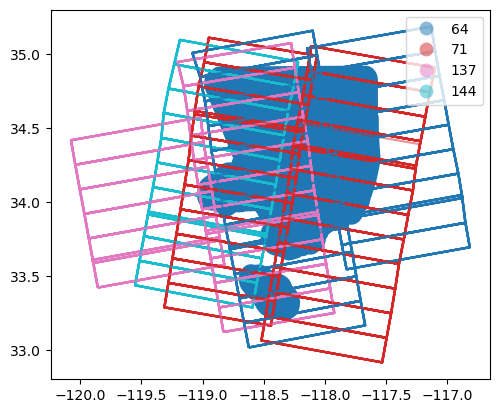

In [14]:
fig, ax = plt.subplots()

df_aoi.plot(ax=ax)
df_rtc_resp_plot = df_rtc_resp.copy()
df_rtc_resp_plot.geometry = df_rtc_resp_plot.geometry.boundary
df_rtc_resp_plot.plot(ax=ax, alpha=.5, column='pathNumber', categorical=True, legend=True)

## Select Path

In [15]:
TRACK_NUMBER = 71

In [16]:
df_rtc_track = df_rtc_resp[df_rtc_resp.pathNumber== TRACK_NUMBER].reset_index(drop=True)
df_rtc_track.acq_date.unique()

array([datetime.date(2025, 1, 10), datetime.date(2024, 12, 29),
       datetime.date(2024, 12, 17), datetime.date(2024, 12, 5),
       datetime.date(2024, 11, 23), datetime.date(2024, 11, 11),
       datetime.date(2024, 10, 30), datetime.date(2024, 10, 18),
       datetime.date(2024, 10, 6), datetime.date(2024, 9, 24),
       datetime.date(2024, 9, 12), datetime.date(2024, 8, 31),
       datetime.date(2024, 8, 19), datetime.date(2024, 8, 7),
       datetime.date(2024, 7, 26), datetime.date(2024, 7, 14)],
      dtype=object)

In [17]:
(df_rtc_track.acq_dt > pd.to_datetime(EVENT_DATE, utc=True)).sum()

23

In [18]:
df_rtc_track['additionalUrls'].tolist()[0]

['https://datapool.asf.alaska.edu/RTC/OPERA-S1/OPERA_L2_RTC-S1_T071-151234-IW2_20250109T135309Z_20250109T180152Z_S1A_30_v1.0.iso.xml',
 'https://datapool.asf.alaska.edu/RTC/OPERA-S1/OPERA_L2_RTC-S1_T071-151234-IW2_20250109T135309Z_20250109T180152Z_S1A_30_v1.0_VH.tif',
 'https://datapool.asf.alaska.edu/RTC/OPERA-S1/OPERA_L2_RTC-S1_T071-151234-IW2_20250109T135309Z_20250109T180152Z_S1A_30_v1.0_VV.tif',
 'https://datapool.asf.alaska.edu/RTC/OPERA-S1/OPERA_L2_RTC-S1_T071-151234-IW2_20250109T135309Z_20250109T180152Z_S1A_30_v1.0_mask.tif']

In [19]:
def get_url_tif(row: pd.Series, polarization='vh') -> str:
    if polarization not in ['vv', 'vh']:
        raise ValueError('polarization not specified correctly')
    urls = [row.url] + row.additionalUrls
    pol_token = '_VH.tif' if polarization=='vh' else '_VV.tif'
    valid_urls = [url for url in urls if pol_token in url]
    if not valid_urls:
        raise ValueError('No urls found')
    tif_url = valid_urls[0]
    return tif_url

In [20]:
get_url_tif_vv = lambda row: get_url_tif(row, polarization='vv')
df_rtc_track['vh_url'] = df_rtc_track.apply(get_url_tif, axis=1)
df_rtc_track['vv_url'] = df_rtc_track.apply(get_url_tif_vv, axis=1)
df_rtc_track['burst_id'] = df_rtc_track.fileID.map(lambda file_id: file_id.split('_')[3])


In [21]:
df_rtc_track['vv_url'].tolist()[0]

'https://datapool.asf.alaska.edu/RTC/OPERA-S1/OPERA_L2_RTC-S1_T071-151234-IW2_20250109T135309Z_20250109T180152Z_S1A_30_v1.0_VV.tif'

In [22]:
df_rtc_track['vh_url'].tolist()[0]

'https://datapool.asf.alaska.edu/RTC/OPERA-S1/OPERA_L2_RTC-S1_T071-151234-IW2_20250109T135309Z_20250109T180152Z_S1A_30_v1.0_VH.tif'

# Download RTCs by Burst

`out/<AOI_NAME>/rtc_ts/<burst_id>/<tif_files>`

In [23]:
rtc_ts_dir = out_dir / 'rtc_ts' / f'track{TRACK_NUMBER}'
rtc_ts_dir.mkdir(exist_ok=True, parents=True)

In [24]:

@backoff.on_exception(
    backoff.expo,
    [ConnectionError, HTTPError, RasterioIOError],
    max_tries=10,
    max_time=60,
    jitter=backoff.full_jitter,
)
def localize_one_rtc(
    url: str,
    ts_dir: str | Path
) -> Path:
    local_fn = url.split("/")[-1]
    out_path = ts_dir / local_fn
    if not ts_dir.exists():
        ts_dir.mkdir(parents=True)
    if out_path.exists():
        return out_path
        
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(out_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=16384): 
                f.write(chunk)
    return out_path

In [25]:
burst_ids = df_rtc_track.burst_id.tolist()
vv_urls = df_rtc_track.vv_url.tolist()
vh_urls = df_rtc_track.vh_url.tolist()

In [26]:
zipped_inputs = [[url, rtc_ts_dir/ burst_id] for (url, burst_id) in zip(vv_urls + vh_urls, burst_ids * 2)]
zipped_inputs[0]

['https://datapool.asf.alaska.edu/RTC/OPERA-S1/OPERA_L2_RTC-S1_T071-151234-IW2_20250109T135309Z_20250109T180152Z_S1A_30_v1.0_VV.tif',
 PosixPath('out/los-angeles-fire/rtc_ts/track71/T071-151234-IW2')]

In [27]:
def localize_one_rtc_p(data: tuple) -> Path:
    return localize_one_rtc(*data)

In [28]:
# localize_one_rtc(*zipped_inputs[0])

In [29]:
import concurrent.futures

with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    out_paths_rtc = list(tqdm(executor.map(localize_one_rtc_p, zipped_inputs[:]), total=len(zipped_inputs)))

100%|████████████████████████████████████| 730/730 [00:00<00:00, 270218.16it/s]


# Despeckle

In [30]:
from distmetrics import despeckle_rtc_arrs_with_tv

In [31]:
rtc_ts_dir

PosixPath('out/los-angeles-fire/rtc_ts/track71')

In [32]:
tv_dir = rtc_ts_dir.parents[1] / 'rtc_ts_tv' / f'track{TRACK_NUMBER}'
tv_dir.mkdir(exist_ok=True, parents=True)
tv_dir

PosixPath('out/los-angeles-fire/rtc_ts_tv/track71')

In [33]:
burst_ids = [p.parent.stem for p in out_paths_rtc]
burst_ids[:3]

['T071-151234-IW2', 'T071-151233-IW3', 'T071-151233-IW2']

In [34]:
out_paths_rtc_d = [tv_dir / burst_id / p.name for (burst_id, p) in zip(burst_ids, out_paths_rtc)]
out_paths_rtc_d[:3]

[PosixPath('out/los-angeles-fire/rtc_ts_tv/track71/T071-151234-IW2/OPERA_L2_RTC-S1_T071-151234-IW2_20250109T135309Z_20250109T180152Z_S1A_30_v1.0_VV.tif'),
 PosixPath('out/los-angeles-fire/rtc_ts_tv/track71/T071-151233-IW3/OPERA_L2_RTC-S1_T071-151233-IW3_20250109T135308Z_20250109T180152Z_S1A_30_v1.0_VV.tif'),
 PosixPath('out/los-angeles-fire/rtc_ts_tv/track71/T071-151233-IW2/OPERA_L2_RTC-S1_T071-151233-IW2_20250109T135307Z_20250109T180152Z_S1A_30_v1.0_VV.tif')]

In [35]:
def open_one(path: Path):
    with rasterio.open(path) as ds:
        X = ds.read(1)
        p = ds.profile
    return X, p

def serialize_one(arr:np.ndarray, p: dict, out_path: Path):
    with rasterio.open(out_path, 'w', **p) as ds:
        ds.write(arr, 1)
    return out_path

def despeckle_and_serialize(rtc_paths: list[Path],
                            dst_paths: list[Path],
                            batch_size=100) -> list:
    # Ensure new directories exist
    [p.parent.mkdir(exist_ok=True, parents=True) for p in dst_paths]
    # one liner for math.ceil
    n_batches = (len(rtc_paths) + batch_size - 1) // batch_size
    for k in tqdm(range(n_batches), desc='batch'):
        paths_subset = rtc_paths[k * batch_size: (k + 1) * batch_size]
        dst_paths_subset = dst_paths[k * batch_size: (k + 1) * batch_size]

        # don't overwrite
        dst_paths_subset = [dst_p for dst_p in dst_paths_subset if not dst_p.exists()]
        paths_subset = [src_p for (src_p, dst_p) in zip(paths_subset, dst_paths_subset) if not dst_p.exists()]
        
        # open
        if dst_paths_subset:
            arrs, ps = zip(*list(map(open_one, paths_subset)))
            # despeckle
            arrs_d = despeckle_rtc_arrs_with_tv(arrs)
            # serialize
            [serialize_one(arr, prof, dst_path) for (arr, prof, dst_path) in zip(arrs_d, ps, dst_paths_subset)]

    return dst_paths

In [36]:
out_paths_rtc_d = despeckle_and_serialize(out_paths_rtc, out_paths_rtc_d, batch_size=100)

batch: 100%|███████████████████████████████████| 8/8 [00:00<00:00, 2628.01it/s]


In [37]:
out_paths_rtc_d[0].stem

'OPERA_L2_RTC-S1_T071-151234-IW2_20250109T135309Z_20250109T180152Z_S1A_30_v1.0_VV'

# Generate Disturbance Map - by Burst

# Create LUT by burst to paths

In [38]:
vv_path_data = [{'burst_id': p.parent.stem, 
                 'vv_path': str(p),
                 'acq_timestamp': pd.to_datetime(p.stem.split('_')[4])} for p in out_paths_rtc_d if 'VV.tif' in p.name]
vv_path_data[:3]

[{'burst_id': 'T071-151234-IW2',
  'vv_path': 'out/los-angeles-fire/rtc_ts_tv/track71/T071-151234-IW2/OPERA_L2_RTC-S1_T071-151234-IW2_20250109T135309Z_20250109T180152Z_S1A_30_v1.0_VV.tif',
  'acq_timestamp': Timestamp('2025-01-09 13:53:09+0000', tz='UTC')},
 {'burst_id': 'T071-151233-IW3',
  'vv_path': 'out/los-angeles-fire/rtc_ts_tv/track71/T071-151233-IW3/OPERA_L2_RTC-S1_T071-151233-IW3_20250109T135308Z_20250109T180152Z_S1A_30_v1.0_VV.tif',
  'acq_timestamp': Timestamp('2025-01-09 13:53:08+0000', tz='UTC')},
 {'burst_id': 'T071-151233-IW2',
  'vv_path': 'out/los-angeles-fire/rtc_ts_tv/track71/T071-151233-IW2/OPERA_L2_RTC-S1_T071-151233-IW2_20250109T135307Z_20250109T180152Z_S1A_30_v1.0_VV.tif',
  'acq_timestamp': Timestamp('2025-01-09 13:53:07+0000', tz='UTC')}]

In [39]:
vh_path_data = [{'burst_id': p.parent.stem, 
                 'vh_path': str(p),
                 'acq_timestamp': pd.to_datetime(p.stem.split('_')[4])} for p in out_paths_rtc_d if 'VH.tif' in p.name]
vh_path_data[:3]

[{'burst_id': 'T071-151234-IW2',
  'vh_path': 'out/los-angeles-fire/rtc_ts_tv/track71/T071-151234-IW2/OPERA_L2_RTC-S1_T071-151234-IW2_20250109T135309Z_20250109T180152Z_S1A_30_v1.0_VH.tif',
  'acq_timestamp': Timestamp('2025-01-09 13:53:09+0000', tz='UTC')},
 {'burst_id': 'T071-151233-IW3',
  'vh_path': 'out/los-angeles-fire/rtc_ts_tv/track71/T071-151233-IW3/OPERA_L2_RTC-S1_T071-151233-IW3_20250109T135308Z_20250109T180152Z_S1A_30_v1.0_VH.tif',
  'acq_timestamp': Timestamp('2025-01-09 13:53:08+0000', tz='UTC')},
 {'burst_id': 'T071-151233-IW2',
  'vh_path': 'out/los-angeles-fire/rtc_ts_tv/track71/T071-151233-IW2/OPERA_L2_RTC-S1_T071-151233-IW2_20250109T135307Z_20250109T180152Z_S1A_30_v1.0_VH.tif',
  'acq_timestamp': Timestamp('2025-01-09 13:53:07+0000', tz='UTC')}]

In [40]:
len(vh_path_data) == df_rtc_track.shape[0]

True

In [41]:
df_vv = pd.DataFrame(vv_path_data)
df_vh = pd.DataFrame(vh_path_data)

df_vv['date_str'] = df_vv.acq_timestamp.dt.date.astype(str)
df_vh['date_str'] = df_vh.acq_timestamp.dt.date.astype(str)
df_loc_ts = pd.merge(df_vv, df_vh[['burst_id', 'date_str', 'vh_path']], on=['burst_id', 'date_str'], how='inner')
df_loc_ts = df_loc_ts[['burst_id', 'acq_timestamp', 'date_str', 'vv_path', 'vh_path']]
df_loc_ts = df_loc_ts.sort_values(by=['burst_id', 'acq_timestamp']).reset_index(drop=True)
assert df_loc_ts.shape[0] == len(vh_path_data)
df_loc_ts.head()

,burst_id,acq_timestamp,date_str,vv_path,vh_path
0,T071-151223-IW2,2024-07-25 13:52:42+00:00,2024-07-25,out/los-angeles-fire/rtc_ts_tv/track71/T071-15...,out/los-angeles-fire/rtc_ts_tv/track71/T071-15...
1,T071-151223-IW2,2024-08-06 13:52:42+00:00,2024-08-06,out/los-angeles-fire/rtc_ts_tv/track71/T071-15...,out/los-angeles-fire/rtc_ts_tv/track71/T071-15...
2,T071-151223-IW2,2024-08-18 13:52:43+00:00,2024-08-18,out/los-angeles-fire/rtc_ts_tv/track71/T071-15...,out/los-angeles-fire/rtc_ts_tv/track71/T071-15...
3,T071-151223-IW2,2024-08-30 13:52:43+00:00,2024-08-30,out/los-angeles-fire/rtc_ts_tv/track71/T071-15...,out/los-angeles-fire/rtc_ts_tv/track71/T071-15...
4,T071-151223-IW2,2024-09-11 13:52:43+00:00,2024-09-11,out/los-angeles-fire/rtc_ts_tv/track71/T071-15...,out/los-angeles-fire/rtc_ts_tv/track71/T071-15...


## Metric - by Burst

In [42]:
transformer_model = load_trained_transformer_model()

In [43]:
burst_ids_unique = df_loc_ts.burst_id.unique().tolist()
len(burst_ids_unique)

23

In [50]:
def open_one_arr(path: Path):
    with rasterio.open(path) as ds:
        X = ds.read(1)

    return X

def compute_distmetric(burst_id: str, 
                       post_image_proximity_to_event: str = 'closest', 
                       max_pre_images: int = 10,
                       min_pre_images: int = 2) -> np.ndarray:
    assert post_image_proximity_to_event in ['closest', 'farthest'] # or maybe earliest or latest is better

    df_ts = df_loc_ts[df_loc_ts.burst_id == burst_id].reset_index(drop=True)
    df_post = df_ts[df_ts.acq_timestamp >= pd.Timestamp(EVENT_DATE, tz='utc')].reset_index(drop=True)
    df_pre = df_ts[df_ts.acq_timestamp < pd.Timestamp(EVENT_DATE, tz='utc')].reset_index(drop=True)

    pre_vv_paths = df_pre.vv_path[-max_pre_images:].tolist()
    pre_vh_paths = df_pre.vh_path[-max_pre_images:].tolist()

    with rasterio.open(pre_vv_paths[0]) as ds:
        ref_profile = ds.profile

    post_ind = 0 if (post_image_proximity_to_event == 'closest') else -1
    post_vv_path = df_post.vv_path.tolist()[post_ind]
    post_vh_path = df_post.vh_path.tolist()[post_ind]
    post_acq_ts = df_post.acq_timestamp.tolist()[post_ind]
    
    if len(pre_vv_paths) < min_pre_images:
        raise ValueError('Not enough pre-images available')

    pre_arrs_vv = list(map(open_one_arr, pre_vv_paths))
    pre_arrs_vh = list(map(open_one_arr, pre_vh_paths))
    post_vv = open_one_arr(post_vv_path)
    post_vh = open_one_arr(post_vh_path)

    metric_ob = compute_transformer_zscore(transformer_model,
                                        pre_arrs_vv,
                                        pre_arrs_vh,
                                        post_vv,
                                        post_vh,
                                        stride=2, 
                                        batch_size=1024,
                                        memory_strategy='low'
                                        )
    return metric_ob, ref_profile, post_acq_ts

In [51]:
# metric, ref_profile, post_acq_ts = compute_distmetric('T150-320248-IW2')

In [52]:
metric_dir = rtc_ts_dir.parents[1] / 'metrics' / f'track{TRACK_NUMBER}'
metric_dir.mkdir(exist_ok=True, parents=True)
metric_dir

PosixPath('out/los-angeles-fire/metrics/track71')

In [ ]:
def compute_metric_and_serialize(burst_id: str) -> Path:
    metric_ob, ref_profile, post_ts = compute_distmetric(burst_id)
    burst_metric_dir = metric_dir / burst_id
    burst_metric_dir.mkdir(exist_ok=True, parents=True)
    out_path = burst_metric_dir / f'transformer_{burst_id}_{str(post_ts.date())}.tif'

    dist = metric_ob.dist
    with rasterio.open(out_path, 'w', **ref_profile) as ds:
        ds.write(dist, 1)
    return out_path

In [ ]:
metric_paths = list(map(compute_metric_and_serialize, tqdm(burst_ids_unique, desc='burst_id')))

burst_id:   0%|                                         | 0/23 [00:00<?, ?it/s]

### Merge and Serialize

In [ ]:
metric_crs_dir = rtc_ts_dir.parents[1] / 'metrics_crs' / f'track{TRACK_NUMBER}'
metric_crs_dir.mkdir(exist_ok=True, parents=True)

### Most frequent CRS

In [ ]:
def get_crs(path: Path) -> CRS:
    with rasterio.open(path) as ds:
        crs = ds.crs
    return crs

In [ ]:
crs_l = list(map(get_crs, metric_paths))
def most_common(lst):
    return max(set(lst), key=lst.count)

crs_ref = most_common(crs_l)
crs_ref

In [ ]:
def reproject_to_shared_crs_and_serialize(path: Path, ref_crs: CRS):
    with rasterio.open(path) as ds:
        X = ds.read(1)
        p = ds.profile

    out_path = metric_crs_dir / path.name
    
    if p['crs'] == ref_crs:
        shutil.copy(path, out_path)
        return out_path
    else:
        p_crs = reproject_profile_to_new_crs(p_src, ref_crs)
        X_r, p_r = reproject_arr_to_match_profile(X, p, p_crs)
        with rasterio.open(out_path, 'w', **p_r) as ds:
            ds.write(X_r)
    return out_path

In [ ]:
reproject_to_shared_crs_and_serialize_p = lambda path: reproject_to_shared_crs_and_serialize(path, crs_ref)
metric_paths_crs = list(map(reproject_to_shared_crs_and_serialize_p, tqdm(metric_paths)))
metric_paths_crs[:3]

In [ ]:
from rasterio.merge import merge

In [ ]:
X_m, t_m = merge(metric_paths, method='first')

In [ ]:
with rasterio.open(metric_paths[0]) as ds:
    p_met = ds.profile

p_met['transform'] = t_m
p_met['height'], p_met['width'] = X_m.shape[-2:]
tokens = metric_paths[0].stem.split('_')

In [ ]:
track_num_token = tokens[1].split("-")[0]
date_token = tokens[2]
with rasterio.open(metric_crs_dir / f'__merged_{track_num_token}_{tokens[2]}.tif', 'w', **p_met) as ds:
    ds.write(X_m)

# Water Mask (TODO)

# Generate Disturbance Map

In [ ]:
dist_dir = rtc_ts_dir.parents[1] / 'dist_map' / f'track{TRACK_NUMBER}'
dist_dir.mkdir(exist_ok=True, parents=True)
dist_dir

In [ ]:
X_d = np.zeros(X_m.shape[-2:], dtype=np.uint8)

In [ ]:
spatial_mask = np.isnan(X_m[0, ...])
X_d[spatial_mask] = 255

# order will matter here
aggressive_range = (X_m[0, ...] >=2.5)
X_d[aggressive_range] = 1
conservative_range = (X_m[0, ...] >=4.5)
X_d[conservative_range] = 2

## Nice Colormap

In [ ]:
colormap = {
    0: (255, 255, 255, 255),  # white, fully opaque
    1: (255, 204, 204, 255),  # light red, fully opaque
    2: (255, 0, 0, 255),      # red, fully opaque
    255: (0, 0, 0, 0)         # transparent for nodata
}

In [ ]:
tokens = metric_paths[0].stem.split('_')
tokens

In [ ]:
date_token = tokens[-1]

In [ ]:
p_dist = p_met.copy()
p_dist['dtype'] = 'uint8'
p_dist['nodata'] = 255

out_dist_path = dist_dir / f'disturbance_track{TRACK_NUMBER}_{date_token}.tif'
with rasterio.open(out_dist_path, 'w', **p_dist) as ds:
    ds.write(X_d, 1)
    ds.write_colormap(1, colormap)

In [ ]:
cmap = ListedColormap([np.array(colormap.get(key, (255, 255, 255, 255))) / 255 for key in range(256)])

In [ ]:
plt.imshow(X_d, cmap=cmap, interpolation='none')